In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import seaborn as sns

In [2]:
try:
    result_filename = str(snakemake.input.results)
    marginal_accuracy_filename = str(snakemake.input.marginal_accuracy)
    rhat_filename = str(snakemake.input.rhats)
    figdir = "latex/figures/us-census/"
except NameError:
    result_filename = "../../../results/us-census/results.csv"
    marginal_accuracy_filename = "../../../results/us-census/marginal-accuracy-results.csv"
    rhat_filename = "../../../results/us-census/rhats.csv"
    figdir = "../../../latex/figures/us-census/"
df = pd.read_csv(result_filename)
marginal_accuracy_df = pd.read_csv(marginal_accuracy_filename)
rhat_df = pd.read_csv(rhat_filename)

df["1 - IO1"] = 1 - df["IO1"]
df["1 - IO2"] = 1 - df["IO2"]
df["algo_m"] = df["data_generation_algorithm"] + " " + df["n_syn_datasets"].apply(str)
df["conf_level"] = df.conf_level.apply(lambda x: round(x, 2))
df["dropped_datasets"] = 1 - df["final_n_syn_datasets"] / df["n_syn_datasets"]

In [3]:
with open(str("../../../datasets/us-census/orig_result.p"), "rb") as file:
    orig_result_object = pickle.load(file)

orig_result = orig_result_object["orig_result"]
orig_cis = orig_result.conf_int(1 - 0.95)
orig_ci_widths = orig_cis.loc[:, 1] - orig_cis.loc[:, 0]
orig_ci_widths

const          0.037866
iSex_1         0.103981
iVietnam_1     0.066221
iKorean_1      0.084382
iMilitary_1    0.073785
iMilitary_3    0.093243
dtype: float64

In [4]:
conf_levels = [0.8, 0.85, 0.9, 0.95]
all_conf_levels = list(np.linspace(0.05, 0.95, 19)) # = [0.05, 0.1, 0.15, ..., 0.9, 0.95]

In [5]:
c_df = df.drop(columns=["data_generation_algorithm", "type"])
cols_to_group_by = ["epsilon", "algo_m", "conf_level", "repeat_ind"]
agg_functions = {col: np.mean for col in c_df.columns if col not in cols_to_group_by}
agg_functions["length"] = np.median
agg_functions["length_ratio"] = np.median
group_df = c_df.groupby(cols_to_group_by, as_index=False).agg(
    agg_functions
)

In [6]:
plt.style.use("default")

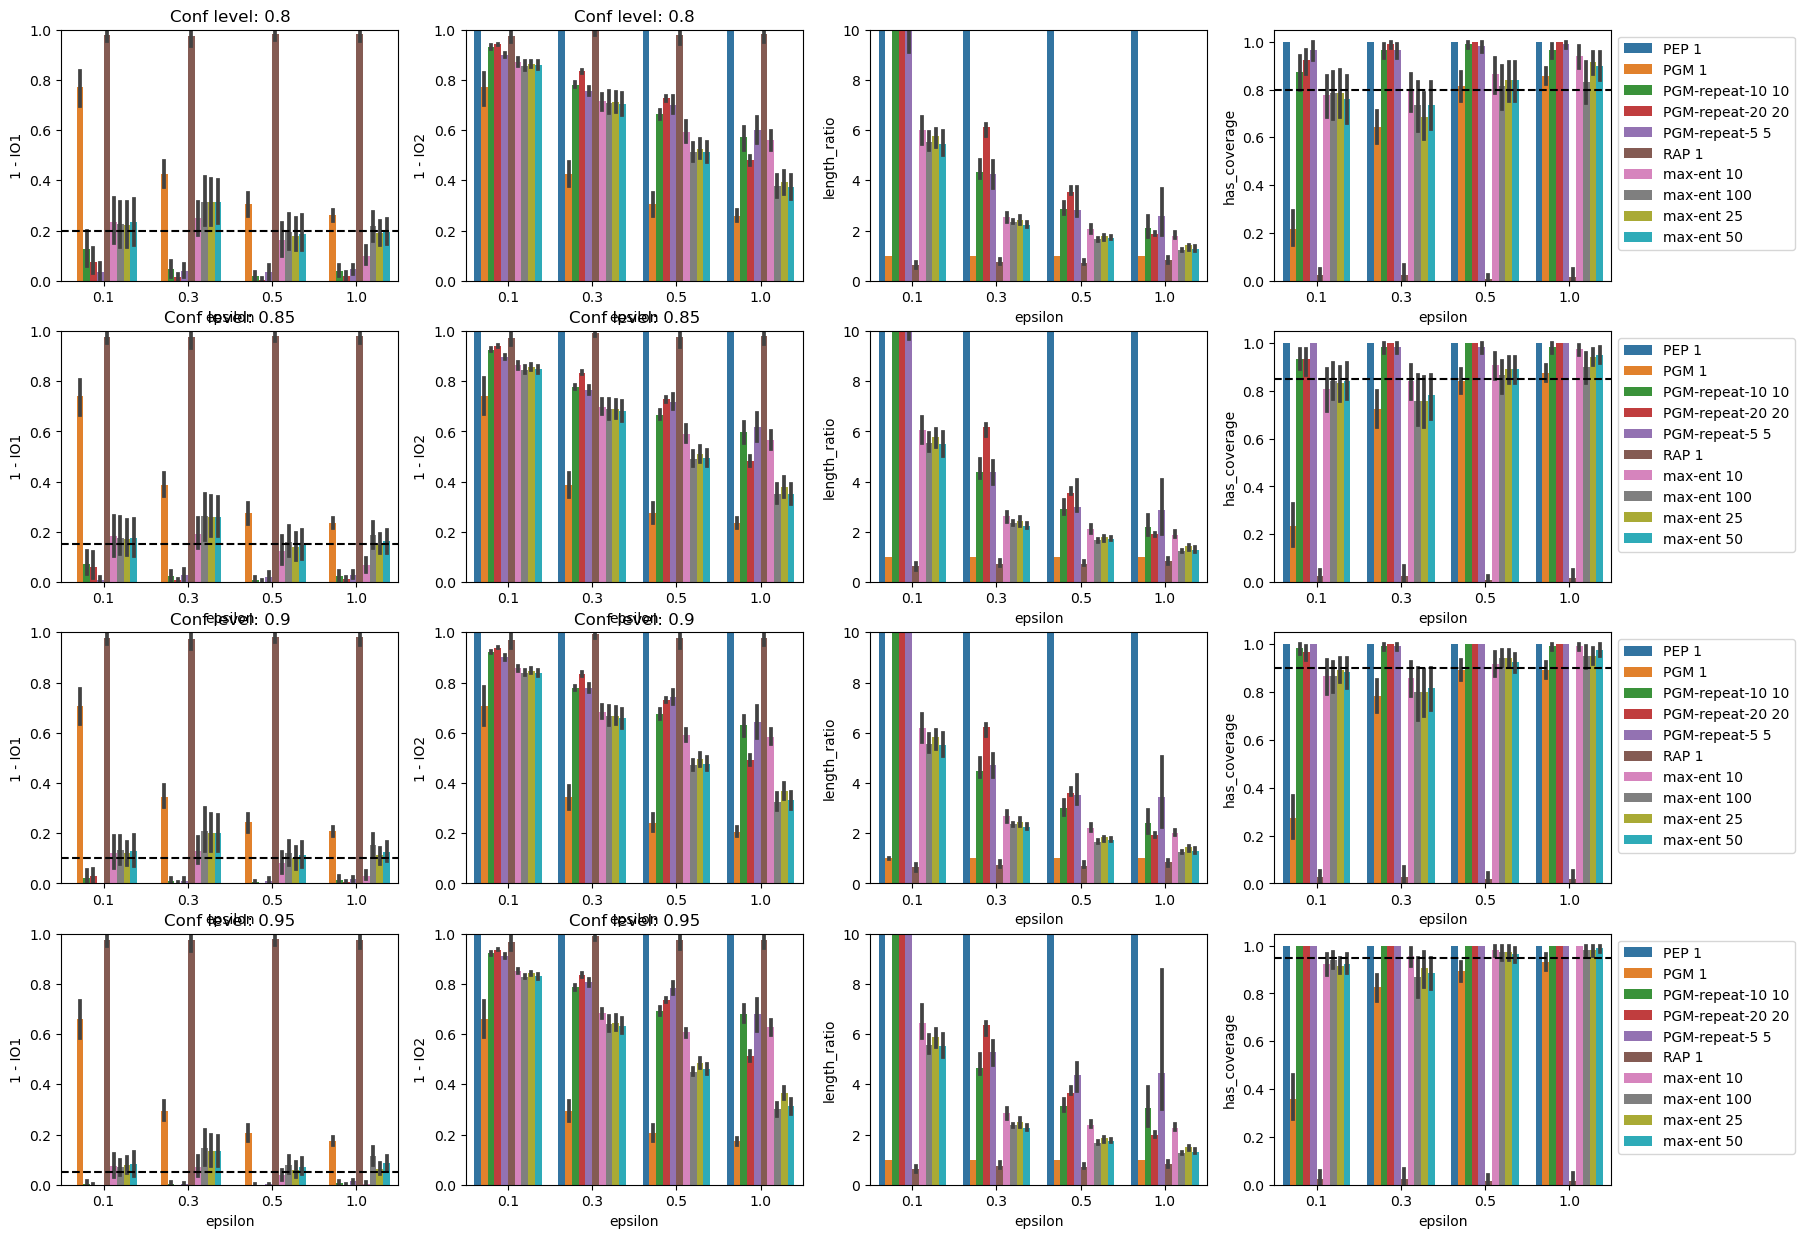

In [7]:
fig, axes = plt.subplots(len(conf_levels), 4, figsize=(20, 15))
for i, conf_level in enumerate(conf_levels):
    cl_df = group_df[group_df["conf_level"] == conf_level].copy()
    sns.barplot(x="epsilon", y="1 - IO1", hue="algo_m", data=cl_df, ax=axes[i, 0])
    sns.barplot(x="epsilon", y="1 - IO2", hue="algo_m", data=cl_df, ax=axes[i, 1])
    sns.barplot(x="epsilon", y="length_ratio", hue="algo_m", data=cl_df, ax=axes[i, 2], estimator=np.median)
    sns.barplot(x="epsilon", y="has_coverage", hue="algo_m", data=cl_df, ax=axes[i, 3])
    axes[i, 0].axhline(1 - conf_level, linestyle="dashed", color="black")
    axes[i, 3].axhline(conf_level, linestyle="dashed", color="black")
    axes[i, 0].set_ylim(0, 1)
    axes[i, 1].set_ylim(0, 1)
    axes[i, 2].set_ylim(0, 10)
    axes[i, 0].set_title("Conf level: {}".format(conf_level))
    axes[i, 1].set_title("Conf level: {}".format(conf_level))
    axes[i, 0].get_legend().remove()
    axes[i, 1].get_legend().remove()
    axes[i, 2].get_legend().remove()
    axes[i, 3].legend(loc="upper left", bbox_to_anchor=(1, 1))

plt.savefig(figdir + "general_metrics.pdf")
plt.show()

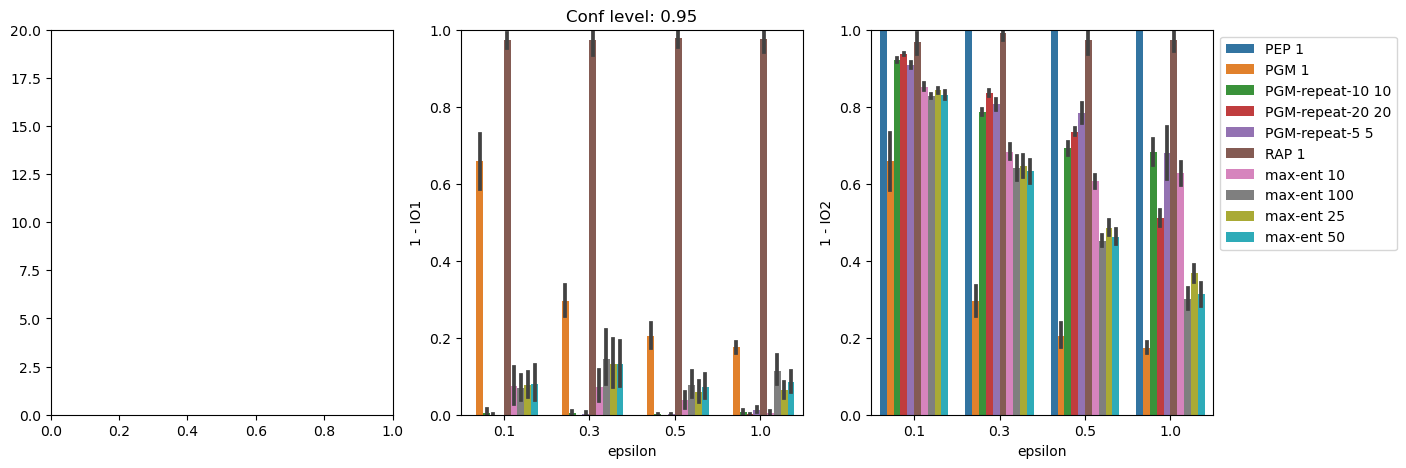

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
kl_df = group_df[group_df["conf_level"] == 0.95]
sns.barplot(x="epsilon", y="1 - IO1", hue="algo_m", data=cl_df, ax=axes[1])
sns.barplot(x="epsilon", y="1 - IO2", hue="algo_m", data=cl_df, ax=axes[2])
axes[1].set_ylim(0, 1)
axes[2].set_ylim(0, 1)
axes[0].set_ylim(0, 20)
axes[1].set_title("Conf level: {}".format(0.95))
axes[1].get_legend().remove()
axes[2].legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.savefig(figdir + "metrics_0.95.pdf")
plt.show()

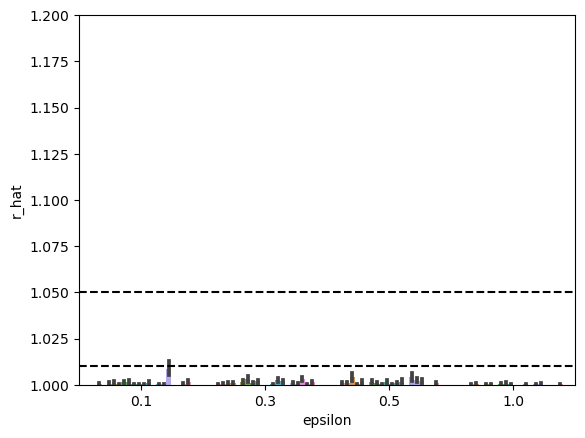

In [9]:
sns.barplot(x="epsilon", y="r_hat", hue="repeat_ind", data=rhat_df, estimator=np.mean)
plt.ylim((1, 1.2))
plt.gca().get_legend().remove()
plt.axhline(1.05, color="black", linestyle="dashed")
plt.axhline(1.01, color="black", linestyle="dashed")
# plt.savefig(figdir + "max_rhats.pdf")
plt.show()

/var/folders/cq/c5v9d5vs6lsf5rwlb9s1f47jkxhqd5/T/ipykernel_96461/2530651532.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  marginal_accuracy_df.data_generation_algorithm.loc[marginal_accuracy_df.data_generation_algorithm == "max-ent"] = "NAPSU-MQ"


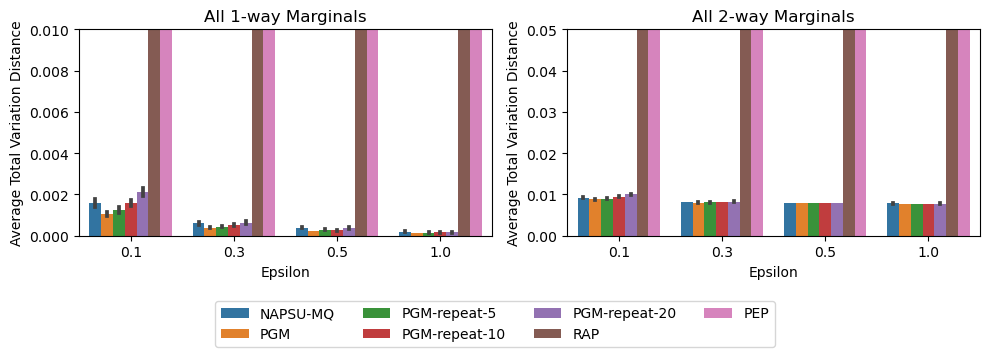

In [10]:
marginal_accuracy_df.data_generation_algorithm.loc[marginal_accuracy_df.data_generation_algorithm == "max-ent"] = "NAPSU-MQ"
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
ax = axes[0]
sns.barplot(x="epsilon", y="marginal-1way-accuracy", hue="data_generation_algorithm", data=marginal_accuracy_df, ax=ax)
leg_h, leg_l = ax.get_legend_handles_labels()
ax.get_legend().remove()
ax.set_xlabel("Epsilon")
ax.set_ylabel("Average Total Variation Distance")
ax.set_title("All 1-way Marginals")
ax.set_ylim((0, 0.01))
ax = axes[1]
sns.barplot(x="epsilon", y="marginal-2way-accuracy", hue="data_generation_algorithm", data=marginal_accuracy_df, ax=ax)
ax.get_legend().remove()
ax.set_xlabel("Epsilon")
ax.set_ylabel("Average Total Variation Distance")
ax.set_title("All 2-way Marginals")
ax.set_ylim((0, 0.05))

fig.legend(leg_h, leg_l, ncol=4, loc="upper center", bbox_to_anchor=(0.5, -0.00))
plt.tight_layout()
plt.savefig(figdir + "marginal-accuracy-comparison.pdf", bbox_inches="tight")
plt.show()

In [11]:
epsilons = df.epsilon.unique()
def plot_calibration(c_df, axes, diag_lim=(0.0, 1.01), hue_order=None, hue="algo_m"):
    for eps_i, epsilon in enumerate(epsilons):
        ax = axes[eps_i]
        s_df = c_df[c_df.epsilon == epsilon]
        sns.lineplot(x="conf_level", y="has_coverage", hue=hue, markers=True, err_style="band", data=s_df, ax=ax, hue_order=hue_order)
        ax.plot(diag_lim, diag_lim, linestyle="dashed", color="black")
        ax.set_xlim(diag_lim)
        ax.set_ylim(diag_lim)
        if eps_i == len(epsilons) - 1:
            ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
        else:
            ax.get_legend().remove()
        ax.set_title("Epsilon: {}".format(epsilon))
        ax.set_xlabel("Conf Level")
        ax.set_ylabel("Coverage")

def plot_lengths(c_df, axes, hue_order=None, hue="algo_m", ylim=(0, 10), conf_levels_to_plot=conf_levels, y="length_ratio"):
    for i, conf_level in enumerate(conf_levels_to_plot):
        ax = axes[i]
        cl_df = c_df[c_df.conf_level == conf_level]
        sns.barplot(x="epsilon", y=y, hue=hue, data=cl_df, ax=ax, estimator=np.median, hue_order=hue_order)
        ax.axhline(1, color="black", linestyle="dashed")
        ax.set_ylim(ylim)
        ax.set_title("Conf Level: {}".format(conf_level))
        ax.set_xlabel("Epsilon")
        ax.set_ylabel("Width Ratio")
        if i != len(conf_levels_to_plot) - 1:
            ax.get_legend().remove()
        else:
            ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

In [12]:
algo_ms_to_plot = ["PGM-repeat-10 10", "max-ent 100", "PGM 1", "RAP 1", "PEP 1"]
epsilons = df.epsilon.unique()
dims = df.dimension.unique()

/var/folders/cq/c5v9d5vs6lsf5rwlb9s1f47jkxhqd5/T/ipykernel_96461/543729996.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  c_df = df.groupby(["conf_level", "dimension", "algo_m", "epsilon", "repeat_ind"], as_index=False).mean()


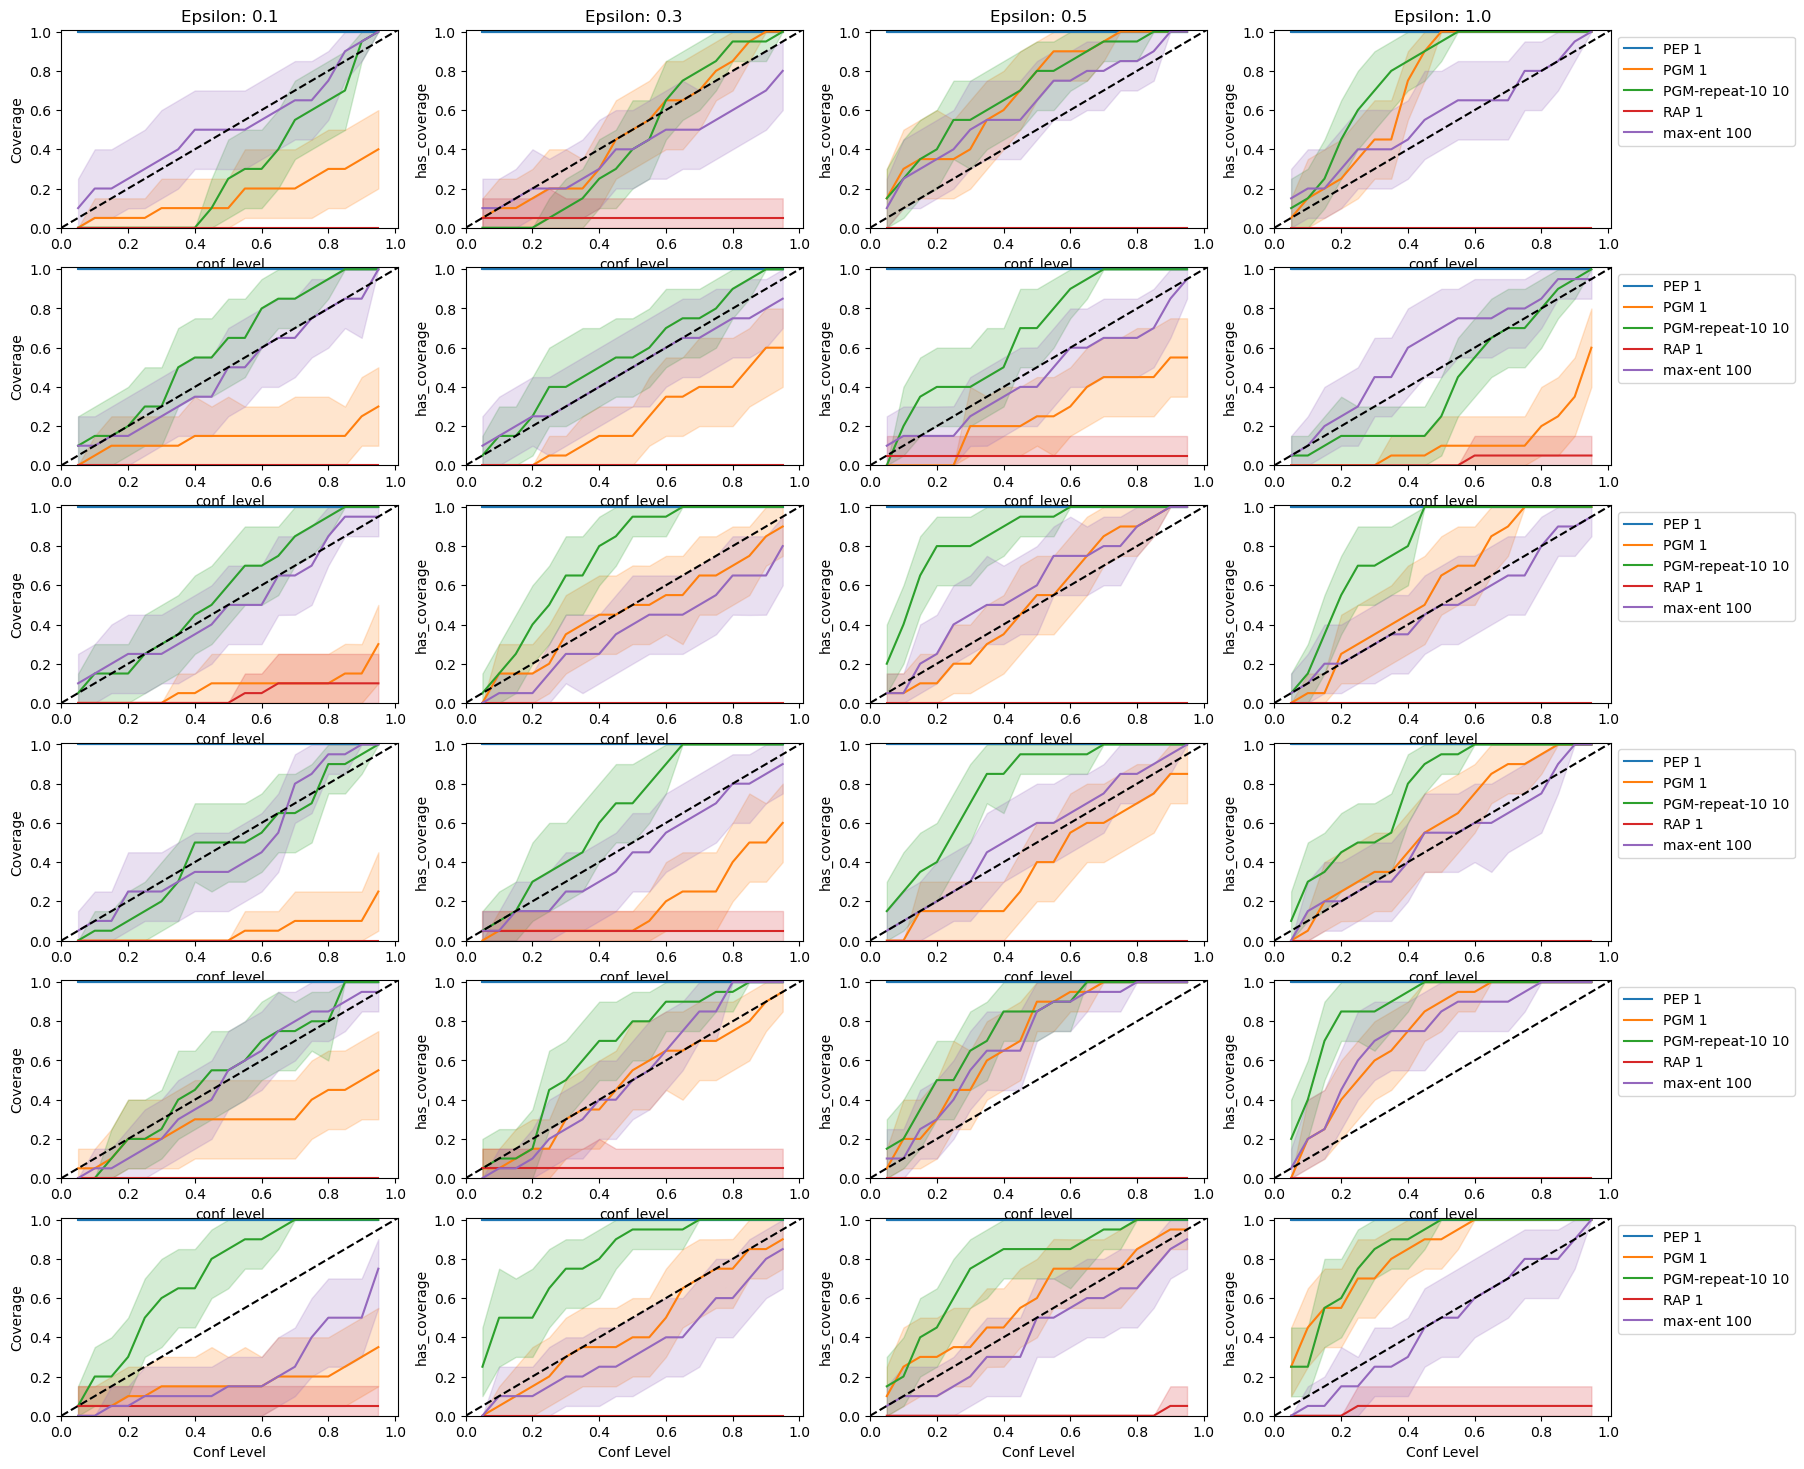

In [13]:
c_df = df.groupby(["conf_level", "dimension", "algo_m", "epsilon", "repeat_ind"], as_index=False).mean()
c_df = c_df[c_df.algo_m.apply(lambda a: a in algo_ms_to_plot)]
fig, axes = plt.subplots(len(dims), len(epsilons), figsize=(5*len(epsilons), 3*len(dims)), squeeze=False)
for eps_i, epsilon in enumerate(epsilons):
    for dim_i, dim in enumerate(dims):
        ax = axes[dim_i, eps_i]
        s_df = c_df[c_df.dimension == dim]
        s_df = s_df[s_df.epsilon == epsilon]
        sns.lineplot(x="conf_level", y="has_coverage", hue="algo_m", markers=True, err_style="band", data=s_df, ax=ax)
        diag = (0.0, 1.01)
        ax.plot(diag, diag, linestyle="dashed", color="black")
        ax.set_xlim(diag)
        ax.set_ylim(diag)
        if eps_i == len(epsilons) - 1:
            ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
        else:
            ax.get_legend().remove()
        axes[dim_i, 0].set_ylabel("Coverage")
    axes[0, eps_i].set_title("Epsilon: {}".format(epsilon))
    axes[-1, eps_i].set_xlabel("Conf Level")
plt.savefig(figdir + "coverage_calibration.pdf")
plt.show()

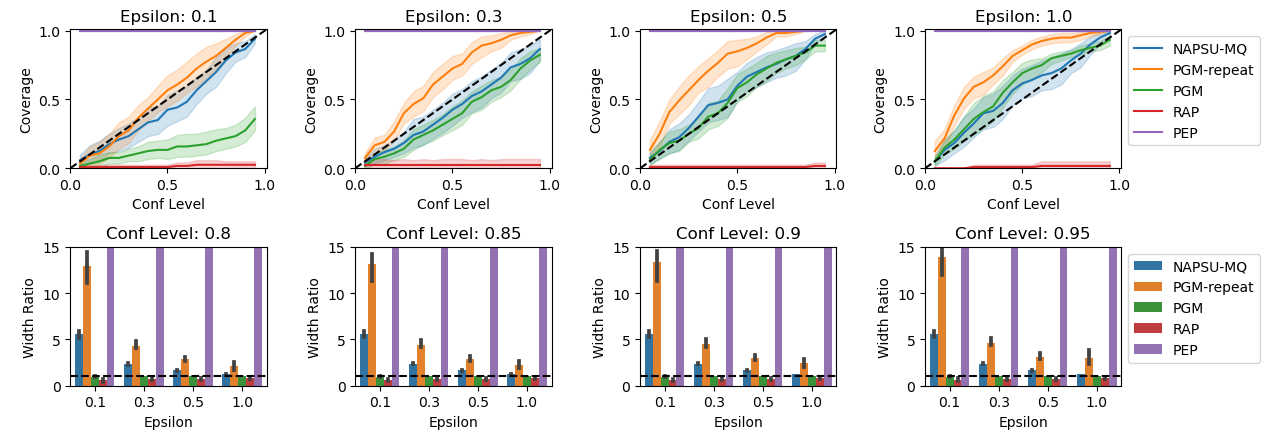

In [14]:
algorithm_labels = {"max-ent": "NAPSU-MQ", "PGM-repeat-10": "PGM-repeat", "PGM": "PGM", "RAP": "RAP", "PEP": "PEP"}
c_df = df.groupby(["conf_level", "algo_m", "data_generation_algorithm", "epsilon", "repeat_ind"], as_index=False).agg(
    {"length": np.median, "length_ratio": np.median, "has_coverage": np.mean}
)
c_df = c_df[c_df.algo_m.apply(lambda a: a in algo_ms_to_plot)]
c_df.data_generation_algorithm = c_df.data_generation_algorithm.map(algorithm_labels)
fig, axes = plt.subplots(2, len(epsilons), figsize=(3.2*len(epsilons), 4.5))
plot_calibration(c_df, axes[0, :], hue="data_generation_algorithm", hue_order=list(algorithm_labels.values()))
plot_lengths(c_df, axes[1, :], hue="data_generation_algorithm", ylim=(0, 15), hue_order=list(algorithm_labels.values()))
plt.tight_layout()
plt.savefig(figdir + "coverage_calibration_mean+lengths.pdf")
plt.show()

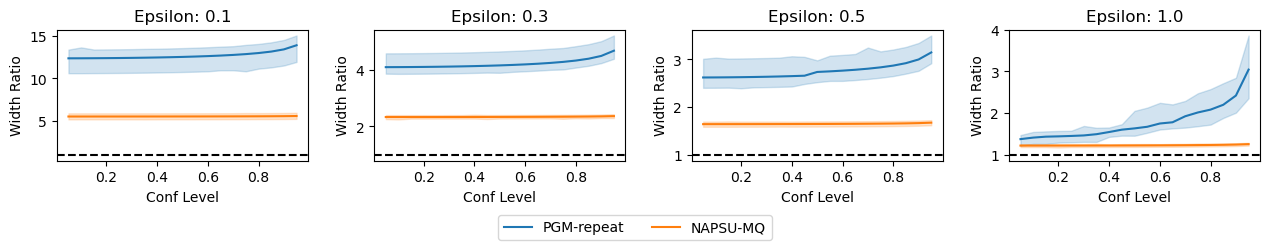

In [15]:
c_df = c_df[(c_df.data_generation_algorithm == "NAPSU-MQ") | (c_df.data_generation_algorithm == "PGM-repeat")]
fig, axes = plt.subplots(1, len(epsilons), figsize=(3.2 * len(epsilons), 2.25), squeeze=False)
for i, eps in enumerate(epsilons):
    ax = axes[0, i]
    s_df = c_df[c_df["epsilon"] == eps]
    sns.lineplot(
        x="conf_level", y="length_ratio", data=s_df, 
        hue="data_generation_algorithm", 
        estimator=np.median, 
        ax=ax
    )
    ax.axhline(1, color="black", linestyle="dashed")
    ax.set_xlabel("Conf Level")
    ax.set_ylabel("Width Ratio")
    ax.set_title("Epsilon: {}".format(eps))
    ax.get_legend().remove()

leg_h, leg_l = axes[0, 0].get_legend_handles_labels()
fig.legend(leg_h, leg_l, loc="upper center", ncol=3, bbox_to_anchor=(0.5, 0.05))
plt.tight_layout()
plt.savefig(figdir + "conf_level_width_ratio_tradeoff.pdf")
plt.show()

/var/folders/cq/c5v9d5vs6lsf5rwlb9s1f47jkxhqd5/T/ipykernel_96461/76987322.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  c_df = df.groupby(["conf_level", "dimension", "algo_m", "epsilon", "repeat_ind", "data_generation_algorithm"], as_index=False).mean()


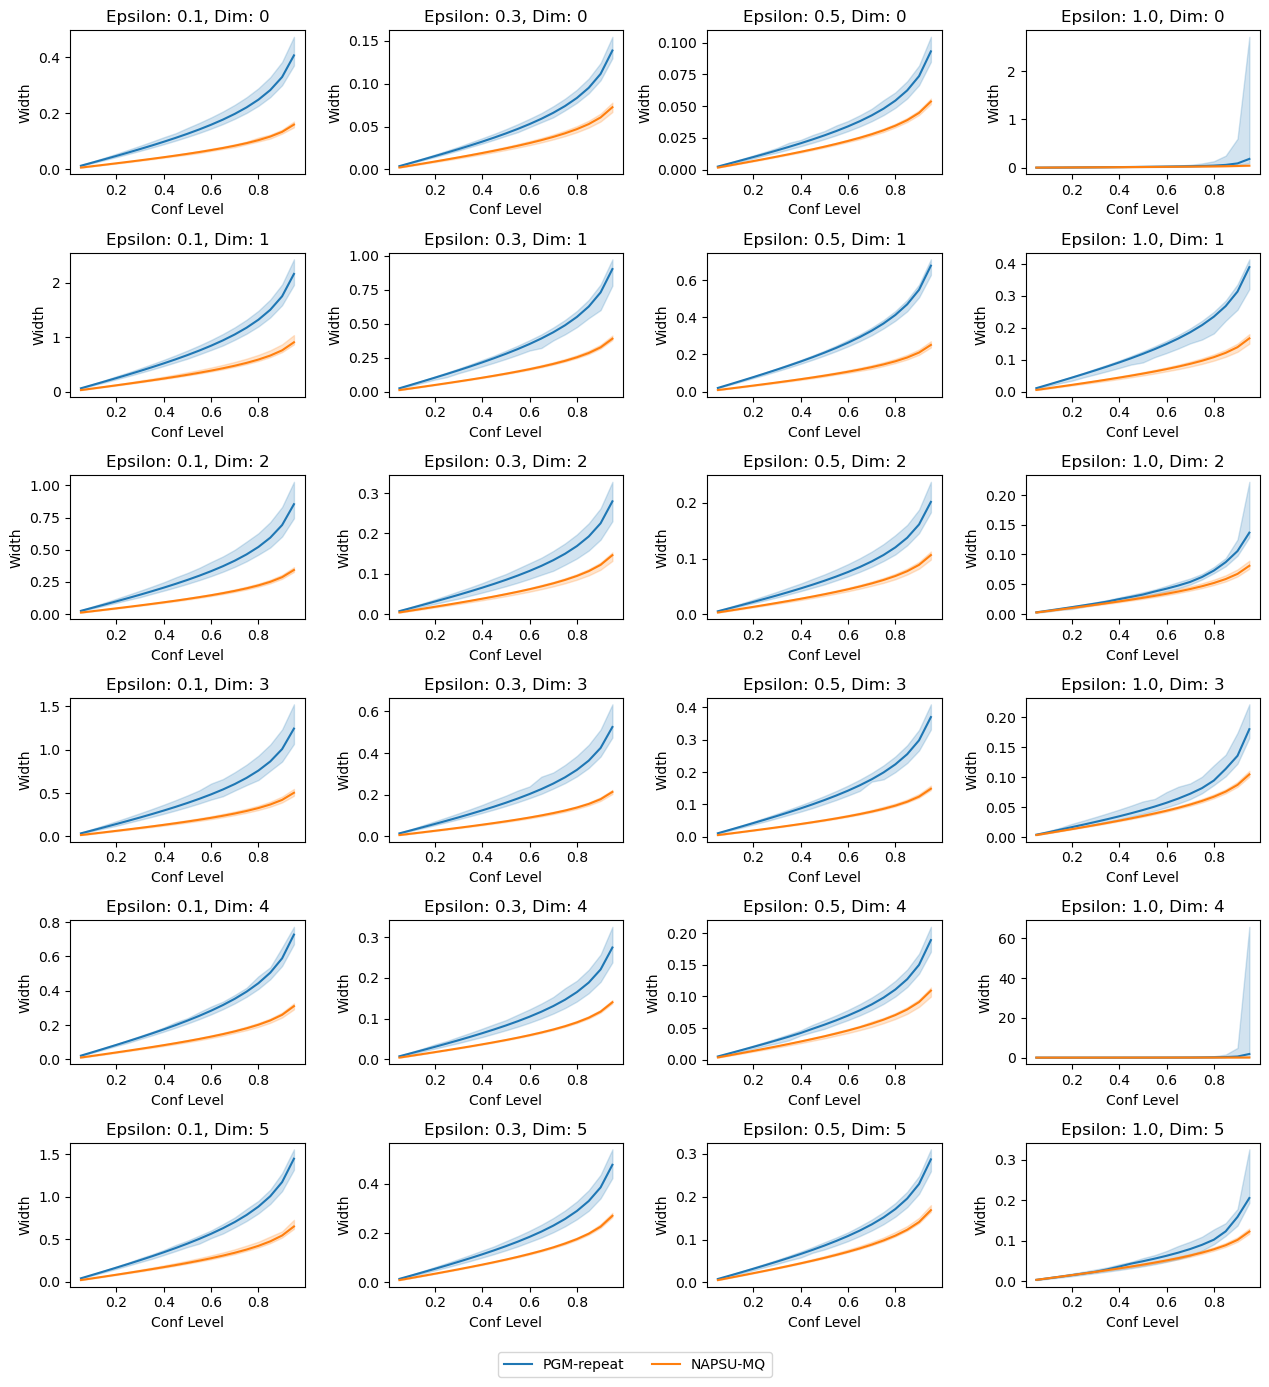

In [16]:
c_df = df.groupby(["conf_level", "dimension", "algo_m", "epsilon", "repeat_ind", "data_generation_algorithm"], as_index=False).mean()
c_df = c_df[c_df.algo_m.apply(lambda a: a in algo_ms_to_plot)]
c_df.data_generation_algorithm = c_df.data_generation_algorithm.map(algorithm_labels)
c_df = c_df[(c_df.data_generation_algorithm == "NAPSU-MQ") | (c_df.data_generation_algorithm == "PGM-repeat")]
fig, axes = plt.subplots(len(dims), len(epsilons), figsize=(3.2 * len(epsilons), 2.25 * len(dims)), squeeze=False)
for i, eps in enumerate(epsilons):
    for j, dim in enumerate(dims):
        ax = axes[j, i]
        s_df = c_df[(c_df["epsilon"] == eps) & (c_df["dimension"] == dim)]
        sns.lineplot(
            x="conf_level", y="length", data=s_df, 
            hue="data_generation_algorithm", 
            estimator=np.median, 
            ax=ax
        )
        ax.set_xlabel("Conf Level")
        ax.set_ylabel("Width")
        ax.set_title("Epsilon: {}, Dim: {}".format(eps, dim))
        ax.get_legend().remove()

leg_h, leg_l = axes[0, 0].get_legend_handles_labels()
fig.legend(leg_h, leg_l, loc="upper center", ncol=3, bbox_to_anchor=(0.5, 0.00))
plt.tight_layout()
plt.savefig(figdir + "conf_level_width_tradeoff.pdf")
plt.show()

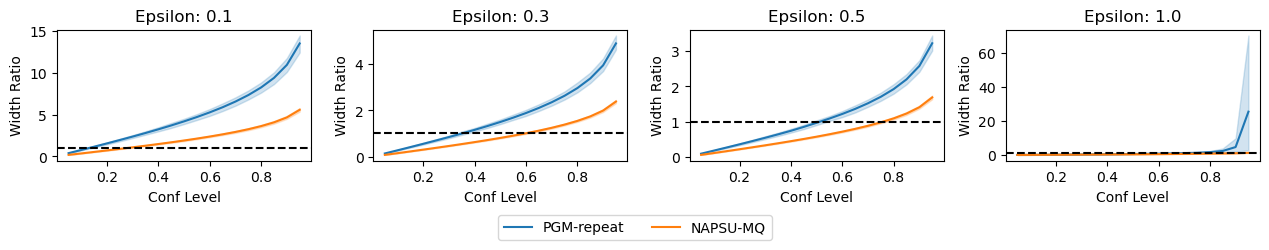

In [17]:
c_df["length_95_ratio"] = c_df.apply(lambda row: row["length"] / orig_ci_widths[row["dimension"]], axis=1)
s_df = c_df.groupby(["conf_level", "algo_m", "epsilon", "repeat_ind", "data_generation_algorithm"], as_index=False).agg(
    {"length": np.median, "length_95_ratio": np.median}
)

fig, axes = plt.subplots(1, len(epsilons), figsize=(3.2*len(epsilons), 2.25))
for i, eps in enumerate(epsilons):
    ax = axes[i]
    ss_df = s_df[s_df["epsilon"] == eps]
    sns.lineplot(x="conf_level", y="length_95_ratio", hue="data_generation_algorithm", data=ss_df, ax=ax)
    ax.axhline(1, color="black", linestyle="dashed")
    ax.set_title("Epsilon: {}".format(eps))
    ax.set_xlabel("Conf Level")
    ax.set_ylabel("Width Ratio")
    ax.get_legend().remove()

leg_h, leg_l = axes[0].get_legend_handles_labels()
fig.legend(leg_h, leg_l, loc="upper center", ncol=3, bbox_to_anchor=(0.5, 0.05))
plt.tight_layout()
plt.savefig(figdir + "conf_level_width_95_tradeoff.pdf", bbox_inches="tight")
plt.show()

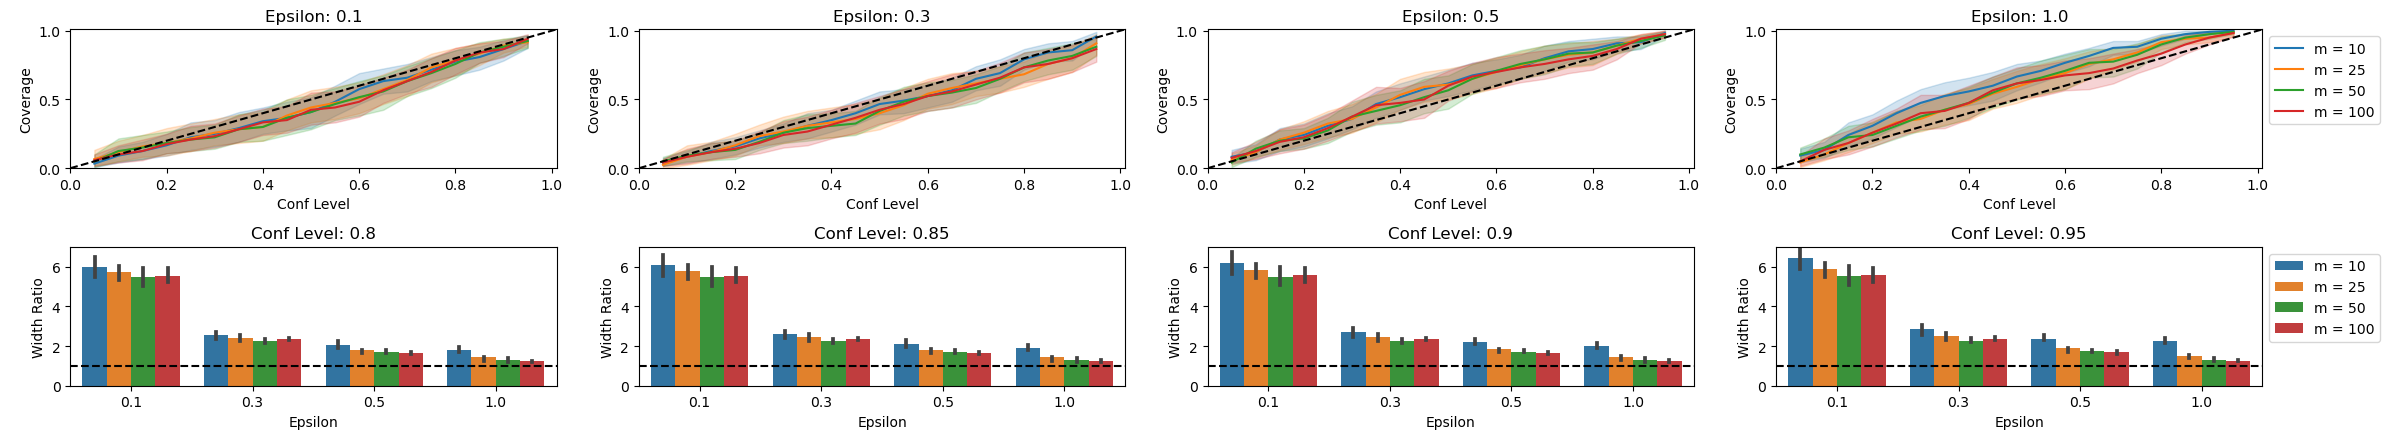

In [18]:
c_df = df.groupby(["conf_level", "algo_m", "data_generation_algorithm", "n_syn_datasets", "epsilon", "repeat_ind"], as_index=False).agg(
    {"length": np.median, "length_ratio": np.median, "has_coverage": np.mean, "dropped_datasets": np.mean}
)
labels = {"max-ent 10": "m = 10", "max-ent 25": "m = 25", "max-ent 50": "m = 50", "max-ent 100": "m = 100"}
hue_order = ["m = 10", "m = 25", "m = 50", "m = 100"]
c_df = c_df[c_df.data_generation_algorithm == "max-ent"]
c_df.algo_m = c_df.algo_m.map(labels)

fig, axes = plt.subplots(2, len(epsilons), figsize=(6*len(epsilons), 4.5), squeeze=False)
plot_calibration(c_df, axes[0, :], hue_order=hue_order)
plot_lengths(c_df, axes[1, :], hue_order=hue_order, ylim=(0, 7))
plt.tight_layout()
plt.savefig(figdir + "max-ent_n_syn_datasets_comparison.pdf")
plt.show()

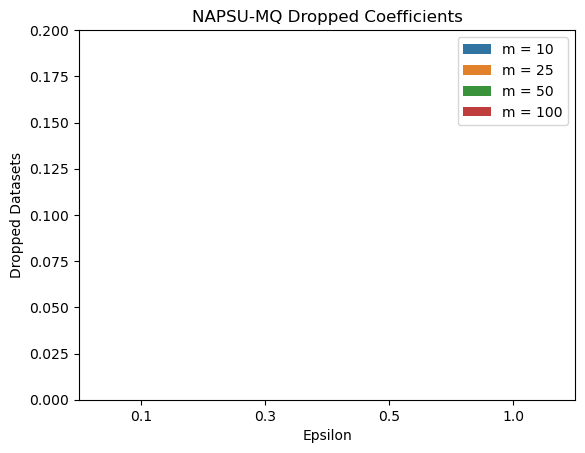

In [19]:
sns.barplot(x="epsilon", y="dropped_datasets", hue="algo_m", data=c_df, hue_order=hue_order)
plt.legend()
plt.xlabel("Epsilon")
plt.ylabel("Dropped Datasets")
plt.ylim((0, 0.2))
plt.title("NAPSU-MQ Dropped Coefficients")
plt.savefig(figdir + "napsu-mq-dropped-datasets.pdf")
plt.show()

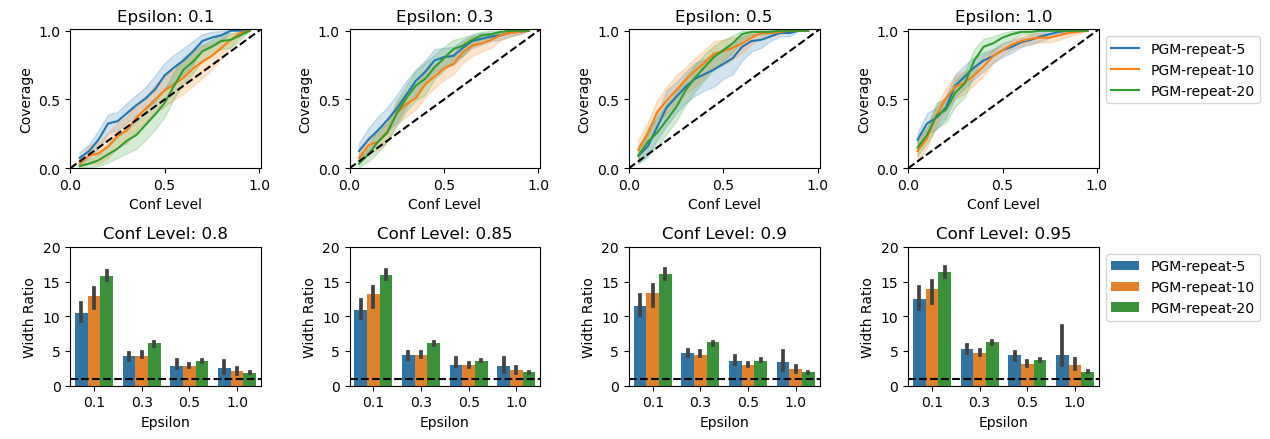

In [20]:
c_df = df.groupby(["conf_level", "algo_m", "data_generation_algorithm", "n_syn_datasets", "epsilon", "repeat_ind"], as_index=False).agg(
    {"length": np.median, "length_ratio": np.median, "has_coverage": np.mean, "dropped_datasets": np.mean}
)
hue_order = ["PGM-repeat-5", "PGM-repeat-10", "PGM-repeat-20"]
c_df = c_df[c_df.data_generation_algorithm.apply(lambda a: a.startswith("PGM-repeat"))]

fig, axes = plt.subplots(2, len(epsilons), figsize=(3.2*len(epsilons), 4.5))
plot_calibration(c_df, axes[0, :], hue_order=hue_order, hue="data_generation_algorithm")
plot_lengths(c_df, axes[1, :], hue_order=hue_order, hue="data_generation_algorithm", ylim=(0, 20))
plt.tight_layout()
plt.savefig(figdir + "pgm_num_repeats_comparison.pdf")
plt.show()

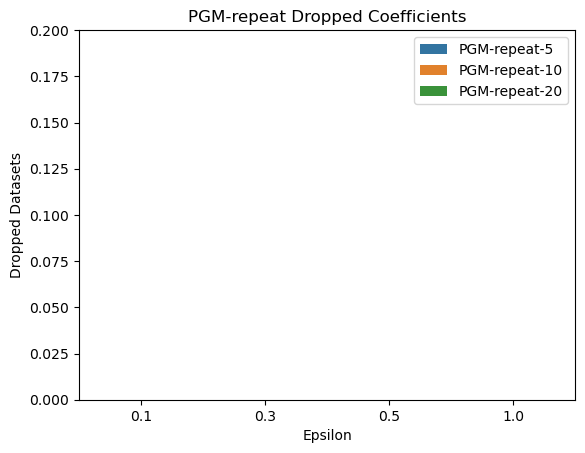

In [21]:
sns.barplot(x="epsilon", y="dropped_datasets", hue="data_generation_algorithm", data=c_df, hue_order=hue_order)
plt.legend()
plt.xlabel("Epsilon")
plt.ylabel("Dropped Datasets")
plt.ylim((0, 0.2))
plt.title("PGM-repeat Dropped Coefficients")
plt.savefig(figdir + "pgm-dropped-datasets.pdf")
plt.show()